# Determining the Correct Orientation of the Post-Surgical T1 MRI To Feed Into Seg3D

Currently, Seg3D outputs segmentations as `.nrrd` files, which seem to also have a fixed RAS orientation. This is a problem if say we would like to overlay the T1 image of the Post-surgery onto the Pre-surgical T1 MRI.

For example, if there is a left/right flip, then the surgical segmentation is on the wrong hemisphere of the brain. 

What our current workflow does is:

0. robustfov: any "neck" is cropped out of the T1 MRI field of view
1. acpcdetect: T1 MRI is acpc aligned and RAS oriented 
2. coregistration: the Post-surgical T1 (acpc, RAS) is coregistered onto the Pre-surgical T1 MRI (acpc, RAS)
3. Seg3D: the coregistered Post-surgical T1 MRI (acpc, RAS) is annotated and outputs a `.nrrd` file with the image volume mask of the surgical segmentation
4. coregistration: The coregistered Post-surgical T1 (acpc, RAS) on the pre-surgical T1 MRI is then again coregistered to the FreeSurfer T1 MRI (256^3 LIA orientation, or we can apply whatever process FreeSurfer does. the coregistration here is a hack)
5. Apply transformation matrix to the seg3d mask to map it correctly to the FreeSurfer space.

Now, the coregistered Post-Surgical T1 from step 4 and the Freesurfer T1 MRI are in the same space and can be overlaid with anatomical masks, white matter masks, etc. 

## Validation
In order to confirm this flow, we currently have Post-Surgical T1 MRI annotated without acpc alignment. It auto orients to RAS. This poses some issues because then the coregistration transformation matrix we apply to get this image to FreeSurfer T1 image is incorrect.

We want to run all the above steps, and do a quick visualization of each: Let us use `la02` as an example.

In [143]:
# load functions
import nibabel as nb
import numpy as np
import nrrd
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from nilearn import plotting, image

In [171]:
# define certain functions
from mne_bids import make_bids_basename
subject = 'la02'
bids_root = Path("C:\\Users\\d0156\\Dropbox\\bids_layout_data")

def show_slices(slices):
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

def overlay_slices(slice1, slice2):
    plt.imshow(slice1.T, cmap="gray", origin="lower", interpolation="none")
    plt.imshow(slice2.T, cmap="gray", origin="lower", interpolation="none", alpha=0.5)

def transform(coords, src_img, dest_img, transform_mat):
    import subprocess
    coords_str = " ".join([str(x) for x in coords])
    cp = subprocess.run(
        "echo %s | img2imgcoord -mm -src %s -dest %s -xfm %s"
        % (coords_str, src_img, dest_img, transform_mat),
        shell=True,
        stdout=subprocess.PIPE,
    )
    transformed_coords_str = cp.stdout.decode("ascii").strip().split("\n")[-1]
    return np.array([float(x) for x in transformed_coords_str.split(" ") if x])

# Load Data

Load the data from step 0-5.

In [138]:
### DEFINE FILE PATHS
# original T1 MRI nifti files
pret1_basename = make_bids_basename(subject=subject, session='presurgery', suffix='T1w.nii')
pret1_fpath = bids_root / f'sub-{subject}' / 'ses-presurgery' / 'anat' / pret1_basename

postt1_basename = make_bids_basename(subject=subject, session='postsurgery', suffix='T1w.nii')
postt1_fpath = bids_root / f'sub-{subject}' / 'ses-postsurgery' / 'anat' / postt1_basename

# after running robust fov on both of them
robustfov_pret1_basename = make_bids_basename(subject=subject, session='presurgery', processing='robustfov', suffix='T1w.nii')
robustfov_pret1_fpath = bids_root / f'sub-{subject}' / 'ses-presurgery' / 'anat' / robustfov_pret1_basename

robustfov_postt1_basename = make_bids_basename(subject=subject, session='postsurgery', processing='inT1', space='RAS', suffix='T1w.nii.gz')
robustfov_postt1_fpath = bids_root / f'sub-{subject}' / 'ses-postsurgery' / 'anat' / robustfov_postt1_basename

# after running acpcdetect on both of them
acpc_pret1_basename = make_bids_basename(subject=subject, session='presurgery', space='RAS', suffix='T1w.nii')
acpc_pret1_fpath = bids_root / f'sub-{subject}' / 'ses-presurgery' / 'anat' / acpc_pret1_basename

acpc_postt1_basename = make_bids_basename(subject=subject, session='postsurgery', space='RAS', suffix='T1w.nii')
acpc_postt1_fpath = bids_root / f'sub-{subject}' / 'ses-postsurgery' / 'anat' / acpc_postt1_basename

# after coregistration post on pre
postonpre_t1_basename = make_bids_basename(subject=subject, session='postonpre', suffix='T1w.nii.gz')
postonpre_t1_fpath = bids_root / f'sub-{subject}' / 'coregistration' / postonpre_t1_basename


In [139]:
# use nibabel and load
postt1 = nb.load(postt1_fpath)
pret1 = nb.load(pret1_fpath)

robustfov_pret1 = nb.load(robustfov_pret1_fpath)
robustfov_postt1 = nb.load(robustfov_postt1_fpath)

acpc_pret1 = nb.load(acpc_pret1_fpath)
acpc_postt1 = nb.load(acpc_postt1_fpath)

postonpre_t1 = nb.load(postonpre_t1_fpath)

# Visualization and Basic Analysis


## RobustFOV

In [140]:
# re-orient to RAS coordinates
ras_robustfov_pret1 = nb.as_closest_canonical(robustfov_pret1)
ras_robustfov_pret1_data = ras_robustfov_pret1.get_fdata()
ras_robustfov_pret1_data.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-presurgery_proc-robustfov_T1w.nii')

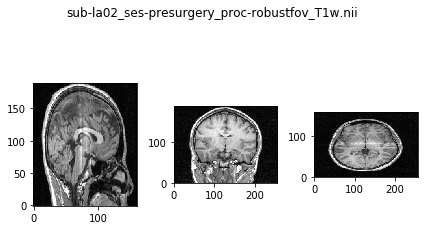

In [80]:
# visualize center slices
slice_0 = ras_robustfov_pret1_data[128, :, :]
slice_1 = ras_robustfov_pret1_data[:, 80, :]
slice_2 = ras_robustfov_pret1_data[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(robustfov_pret1_basename)

In [81]:
# re-orient to RAS coordinates
ras_robustfov_postt1 = nb.as_closest_canonical(robustfov_postt1)
ras_robustfov_postt1_data = ras_robustfov_postt1.get_fdata()
ras_robustfov_postt1_data.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-postsurgery_proc-inT1_space-RAS_T1w.nii.gz')

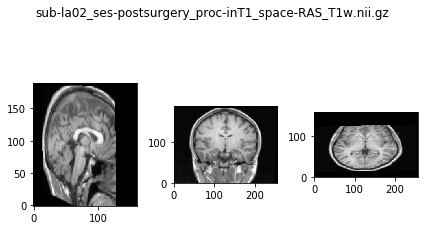

In [82]:
# visualize center slices
slice_0 = ras_robustfov_postt1_data[128, :, :]
slice_1 = ras_robustfov_postt1_data[:, 80, :]
slice_2 = ras_robustfov_postt1_data[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(robustfov_postt1_basename)

## ACPC Detect

In [83]:
# re-orient to RAS coordinates
ras_acpc_pret1 = nb.as_closest_canonical(acpc_pret1)
ras_acpc_pret1_data = ras_acpc_pret1.get_fdata()
ras_acpc_pret1_data.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-presurgery_space-RAS_T1w.nii')

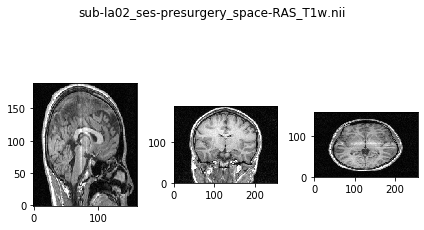

In [84]:
# visualize center slices
slice_0 = ras_acpc_pret1_data[128, :, :]
slice_1 = ras_acpc_pret1_data[:, 80, :]
slice_2 = ras_acpc_pret1_data[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(acpc_pret1_basename)

In [85]:
# re-orient to RAS coordinates
ras_acpc_postt1 = nb.as_closest_canonical(acpc_postt1)
ras_acpc_postt1_data = ras_acpc_postt1.get_fdata()
ras_acpc_postt1_data_squeezed = np.squeeze(ras_acpc_postt1_data, axis=3)
ras_acpc_postt1_data_squeezed.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-postsurgery_space-RAS_T1w.nii')

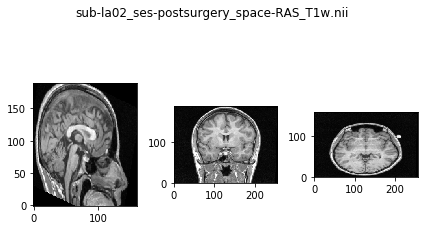

In [86]:
# visualize center slices
slice_0 = ras_acpc_postt1_data_squeezed[128, :, :]
slice_1 = ras_acpc_postt1_data_squeezed[:, 80, :]
slice_2 = ras_acpc_postt1_data_squeezed[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(acpc_postt1_basename)

## First Coregistration Post -> Pre

In [87]:
# re-orient to RAS coordinates
ras_postonpre_t1 = nb.as_closest_canonical(postonpre_t1)
ras_postonpre_t1_data = ras_acpc_postt1.get_fdata()
ras_postonpre_t1_data_squeezed = np.squeeze(ras_postonpre_t1_data, axis = 3)
ras_postonpre_t1_data_squeezed.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-postonpre_T1w.nii.gz')

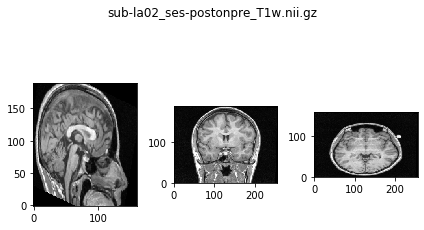

In [88]:
# visualize center slices
slice_0 = ras_postonpre_t1_data_squeezed[128, :, :]
slice_1 = ras_postonpre_t1_data_squeezed[:, 80, :]
slice_2 = ras_postonpre_t1_data_squeezed[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(postonpre_t1_basename)

## Seg3D mask of the Post Coregistered to Pre

In [163]:
# load postmri mask
mask_post_basename = make_bids_basename(subject=subject, session='postsurgery', space='RAS', suffix='T1w.nrrd')
mask_post_fpath = bids_root / f'sub-{subject}' / 'coregistration' / mask_post_basename
mask_post = open(mask_post_fpath, "rb")

# load nrrd file of postmri mask as array
mask_post_data, header = nrrd.read(mask_post_fpath, index_order='F')
print(mask_post_data.shape)

(256, 160, 189)


Text(0.5, 0.98, 'sub-la02_ses-postsurgery_space-RAS_T1w.nrrd')

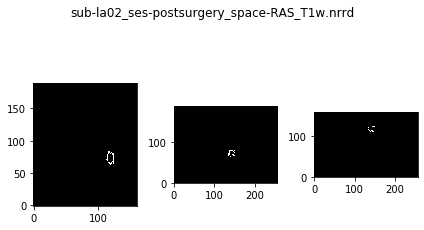

In [164]:
# visualize center slices
slice_0 = mask_post_data[141, :, :]
slice_1 = mask_post_data[:, 122, :]
slice_2 = mask_post_data[:, :, 73]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(mask_post_basename)

Text(0.5, 0.98, 'sub-la02_ses-postsurgery_space-RAS_T1w.nrrd on sub-la02_ses-postsurgery_space-RAS_T1w.nii')

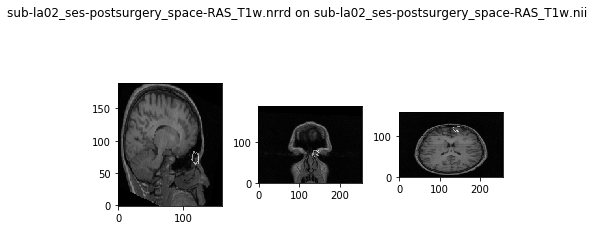

In [181]:
# postmri
slice_0 = ras_postonpre_t1_data_squeezed[141, :, :]
slice_1 = ras_postonpre_t1_data_squeezed[:, 122, :]
slice_2 = ras_postonpre_t1_data_squeezed[:, :, 116]
#show_slices([slice_0, slice_1, slice_2])

# segmentation of postmri
slice_01 = mask_post_data[141, :, :]
slice_11 = mask_post_data[:, 122, :]
slice_21 = mask_post_data[:, :, 73]
#show_slices([slice_0, slice_1, slice_2])

# visualize overlay of postmri and its corresponding segmentation
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(slice_0.T, cmap="gray", origin="lower", interpolation="none")
ax1.imshow(slice_01.T, cmap="gray", origin="lower", interpolation="none", alpha=0.5)

ax2.imshow(slice_1.T, cmap="gray", origin="lower", interpolation="none")
ax2.imshow(slice_11.T, cmap="gray", origin="lower", interpolation="none", alpha=0.5)

ax3.imshow(slice_2.T, cmap="gray", origin="lower", interpolation="none")
ax3.imshow(slice_21.T, cmap="gray", origin="lower", interpolation="none", alpha=0.5)

plt.tight_layout()
plt.suptitle(mask_post_basename + " on " + acpc_postt1_basename)

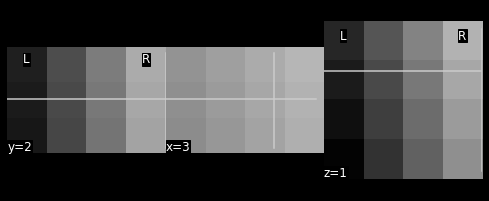

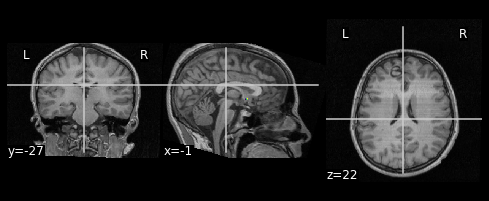

In [179]:
# convert mask to nifti
mask_img = nb.Nifti1Image(mask_post_data, affine=np.eye(4))
display = plotting.plot_anat(new_image) #How to fix?

# overlay mask to postmri
display1 = plotting.plot_anat(ras_acpc_postt1)
display1.add_overlay(new_image)

plotting.show()

## Second Coregistration Post -> Freesurfer Pre

## Seg3D mask mapped to Freesurfer Pre

In [ ]:
# load xfm transformation file
postonpre_mat = bids_root / 'la02' / 'postsurgerymri' / 'sub-la02_from-presurgeryT1w_to-postsurgeryT1w_mode-image_xfm.mat'

In [ ]:
# transform postmri mask to premri
posttopre_data = transform([256, 160, 189], mask_post_data, ras_acpc_pret1_data , postonpre_mat)
print(posttopre_data.shape)